In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from networks import NoKafnet, Kafnet
import utils.datasetsUtils.CIFAR as CIFAR
from utils.datasetsUtils.taskManager import SingleTargetClassificationTask, NoTask
from configs.configs import DefaultConfig, CONFIG_CIFAR10, KAF_CONFIG_CIFAR10
from torchvision.transforms import transforms
import torch
from Trainer import Trainer
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
GeForce GTX 1050


In [4]:
config = CONFIG_CIFAR10()
print(config)

config_kaf = KAF_CONFIG_CIFAR10()
print(config)

CONFIG PARAMETERSBATCH_SIZE: 12
DEVICE: cuda
EPOCHS: 5
EWC_IMPORTANCE: 1000
EWC_SAMPLE_SIZE: 250
IS_CONVOLUTIONAL: True
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: 
OPTIMIZER: SGD
RUN_NAME: default
USE_TENSORBOARD: True

CONFIG PARAMETERSBATCH_SIZE: 12
DEVICE: cuda
EPOCHS: 5
EWC_IMPORTANCE: 1000
EWC_SAMPLE_SIZE: 250
IS_CONVOLUTIONAL: True
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: 
OPTIMIZER: SGD
RUN_NAME: default
USE_TENSORBOARD: True



In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
)

dataset = CIFAR.Cifar10('../data/cifar10', SingleTargetClassificationTask(), download=True,
                        force_download=False, train_split=0.8, transform=transform, target_transform=None)
dataset.load_dataset()

../data/cifar10/download
task #0 with train 48000 and test 12000 images (label: airplane)
task #1 with train 48000 and test 12000 images (label: automobile)
task #2 with train 48000 and test 12000 images (label: bird)
task #3 with train 48000 and test 12000 images (label: cat)
task #4 with train 48000 and test 12000 images (label: deer)
task #5 with train 48000 and test 12000 images (label: dog)
task #6 with train 48000 and test 12000 images (label: frog)
task #7 with train 48000 and test 12000 images (label: horse)
task #8 with train 48000 and test 12000 images (label: ship)
task #9 with train 48000 and test 12000 images (label: truck)


In [6]:
net = NoKafnet.CNN(dataset.tasks_number)
kafnet = Kafnet.KAFCNN(dataset.tasks_number)

print('Numero di parametri rete classica: ', sum([torch.numel(p) for p in net.parameters()]))
print('Numero di parametri KAFNET: ', sum([torch.numel(p) for p in kafnet.parameters()]))

Numero di parametri rete classica:  171732
Numero di parametri KAFNET:  120020


In [7]:
trainerNoKaf = Trainer(net, dataset, config)
trainerKaf = Trainer(kafnet, dataset, config_kaf)

In [8]:
def plot_losses_metrics(losses, metrics):
    fig = plt.figure(figsize=(12, 12))

    x = list(range(len(losses)))
    m = defaultdict(list)

    for item in metrics:
        for k, v in item.items():
            m[k].append(v)

    ax = fig.add_subplot(111)
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    plt.subplot(2, 1, 1)
    ax1.plot(x, losses)
    ax1.set_xlabel('epoch', fontsize=18)
    ax1.set_ylabel('loss', fontsize=16)


    #ax2.set_xlabel('epoch', fontsize=18)
    ax2.set_ylabel('score', fontsize=16)

    for k, values in m.items():         
        ax2.plot(x, values, label=k)
        print()
        #print('epoch {}, loss: {}, evaluation: {}'.format(i,l,m))
    ax2.legend(loc="lower left")
    
    return fig

In [9]:
cnn_losses, cnn_metrics = trainerNoKaf.single_task()

Testing task 0: 100%|██████████| 1000/1000 [00:03<00:00, 330.67it/s, batch#=1e+03]


/home/jary/miniconda3/envs/tesi/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


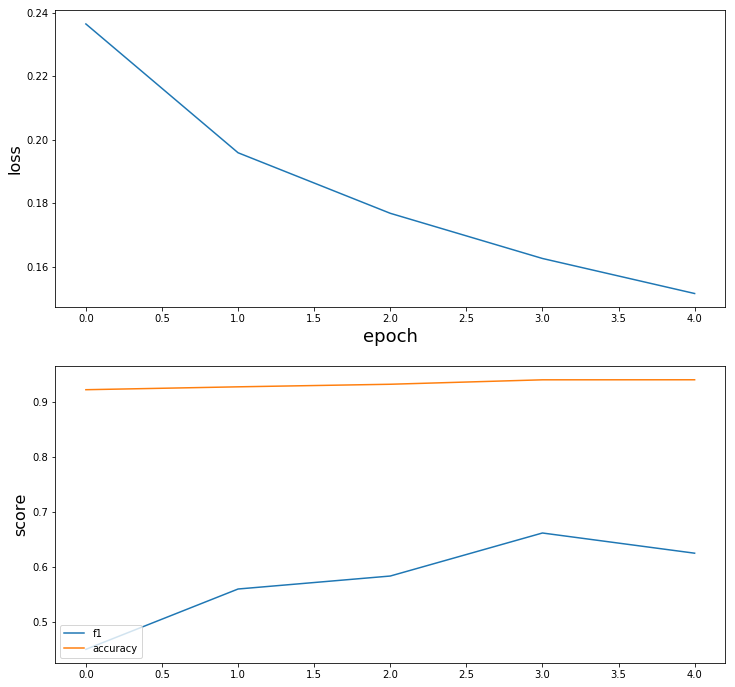

In [10]:
f = plot_losses_metrics(cnn_losses, cnn_metrics)

In [11]:
kaf_loss, kaf_metrics = trainerKaf.single_task()

Testing task 0: 100%|██████████| 1000/1000 [00:11<00:00, 83.53it/s, batch#=1e+03]


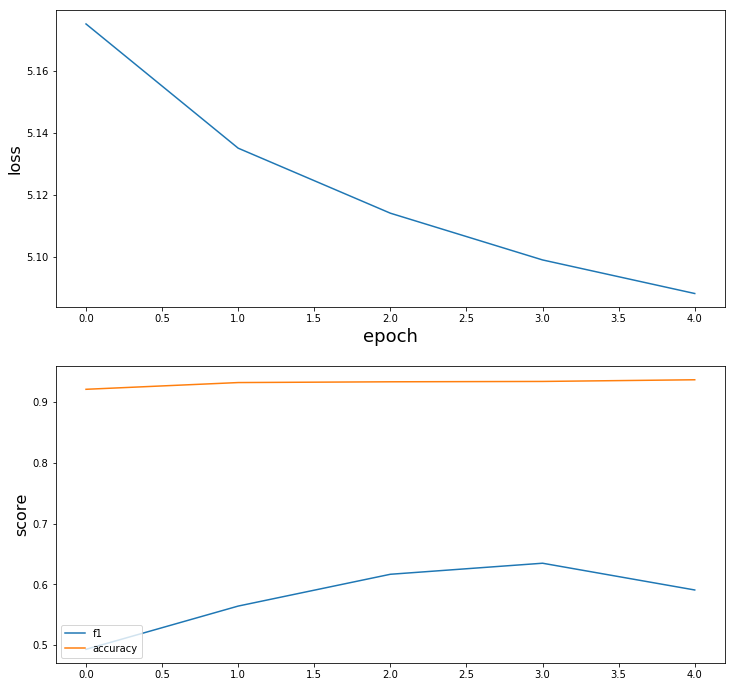

In [12]:
f = plot_losses_metrics(kaf_loss, kaf_metrics)